In [ ]:
#importing modules

import numpy as np

from tqdm import tqdm, trange

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader

from torchvision.transforms import ToTensor
from torchvision.datasets.mnist import MNIST

np.random.seed(0)
torch.manual_seed(0)

Let’s create a main function that prepares the MNIST dataset, instantiates a model, and trains it for 5 epochs.

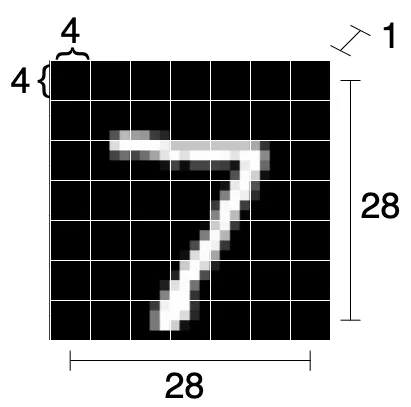After that, the loss and accuracy are measured on the test set.

In [ ]:
def main():
    # Loading data
    transform = ToTensor()

    train_set = MNIST(root='./../datasets', train=True, download=True, transform=transform)
    test_set = MNIST(root='./../datasets', train=False, download=True, transform=transform)

    train_loader = DataLoader(train_set, shuffle=True, batch_size=128)
    test_loader = DataLoader(test_set, shuffle=False, batch_size=128)

    # Defining model and training options
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device: ", device, f"({torch.cuda.get_device_name(device)})" if torch.cuda.is_available() else "")
    model = MyViT((1, 28, 28), n_patches=7, n_blocks=2, hidden_d=8, n_heads=2, out_d=10).to(device)
    N_EPOCHS = 5
    LR = 0.005

    # Training loop
    optimizer = Adam(model.parameters(), lr=LR)
    criterion = CrossEntropyLoss()
    for epoch in trange(N_EPOCHS, desc="Training"):
        train_loss = 0.0
        for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1} in training", leave=False):
            x, y = batch
            x, y = x.to(device), y.to(device)
            y_hat = model(x)
            loss = criterion(y_hat, y)

            train_loss += loss.detach().cpu().item() / len(train_loader)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch + 1}/{N_EPOCHS} loss: {train_loss:.2f}")

    # Test loop
    with torch.no_grad():
        correct, total = 0, 0
        test_loss = 0.0
        for batch in tqdm(test_loader, desc="Testing"):
            x, y = batch
            x, y = x.to(device), y.to(device)
            y_hat = model(x)
            loss = criterion(y_hat, y)
            test_loss += loss.detach().cpu().item() / len(test_loader)

            correct += torch.sum(torch.argmax(y_hat, dim=1) == y).detach().cpu().item()
            total += len(x)
        print(f"Test loss: {test_loss:.2f}")
        print(f"Test accuracy: {correct / total * 100:.2f}%")

Now that we have the above template, from now on, we can just focus on the model (ViT) that will have to classify the images with shape (N x 1 x 28 x 28).

Let’s start by defining an empty nn.Module. We will then fill this class step by step.

In [ ]:
class MyViT(nn.Module):
  def __init__(self):
    # Super constructor
    super(MyViT, self).__init__()

  def forward(self, images):
    pass

**Forward pass**

As Pytorch, as well as most DL frameworks, provides autograd computations, we are only concerned with implementing the forward pass of the ViT model. Since we have defined the optimizer of the model already, the framework will take care of back-propagating gradients and training the model’s parameters.

While implementing a new model, we will keep in mind a picture of the architecture. Here’s our reference picture for the ViT from Bazi et. al (2021):

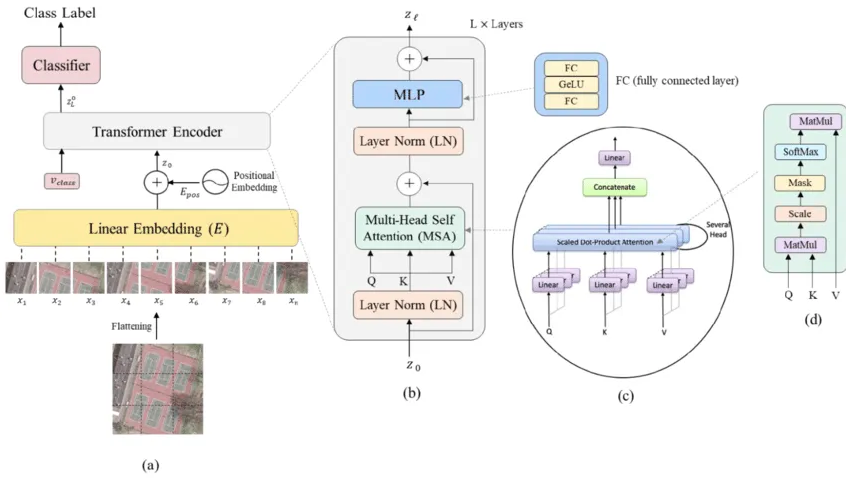

By the picture, we see that the input image (a) is “cut” into sub-images equally sized.

Each such sub-image goes through a linear embedding. From then on, each sub-image is just a one-dimensional vector.

A positional embedding is then added to these vectors (tokens). The positional embedding allows the network to know where each sub-image is positioned originally in the image. Without this information, the network would not be able to know where each such image would be placed, leading to potentially wrong predictions!

These tokens are then passed, together with a special classification token, to the transformer encoders blocks, where each is composed of : A Layer Normalization (LN), followed by a Multi-head Self Attention (MSA) and a residual connection. Then a second LN, a Multi-Layer Perceptron (MLP), and again a residual connection. These blocks are connected back-to-back.

Finally, a classification MLP block is used for the final classification only on the special classification token, which by the end of this process has global information about the picture.

# **Additional Information**

In the Vision Transformer (ViT) model, the Multi-Head Self Attention (MSA) mechanism is a crucial component of the encoder. The self-attention mechanism allows the model to weigh different parts of the input sequence differently when making predictions, enabling it to capture long-range dependencies.

Here's a high-level overview of how Multi-Head Self Attention is typically used in the ViT encoder:

1. **Input Embeddings:**
   - The input image is divided into non-overlapping fixed-size patches, and these patches are linearly embedded to obtain the input embeddings.

2. **Linear Projection:**
   - The embeddings are linearly projected into queries, keys, and values for the self-attention mechanism.

3. **Multi-Head Self Attention:**
   - The queries, keys, and values are split into multiple heads. Each head performs a separate self-attention computation, allowing the model to attend to different aspects of the input.

4. **Scaled Dot-Product Attention:**
   - Each attention head computes scaled dot-product attention independently. This involves computing attention scores by taking the dot product of the queries and keys, scaling the result, applying a softmax function, and then using the attention scores to weight the values.

5. **Concatenation and Linear Projection:**
   - The output from each attention head is concatenated and linearly projected to obtain the final output of the self-attention mechanism.

6. **Residual Connection and Layer Normalization:**
   - The output of the self-attention mechanism is typically passed through a residual connection and layer normalization.

This process is usually repeated multiple times within the ViT encoder, allowing the model to capture hierarchical and multi-scale information from the input image.

It's important to note that while the general architecture is similar to the original transformer model, the specifics of implementation and hyperparameters may vary across different ViT variants and implementations. If you're working with a specific ViT model, it's recommended to refer to the corresponding paper or documentation for detailed information on the architecture and hyperparameters used.

In the context of self-attention mechanisms, including those used in Vision Transformer (ViT) models, the terms "queries," "keys," and "values" refer to three linearly transformed projections of the input embeddings. These projections are crucial components of the attention computation. Here's a brief explanation of each:

1. **Queries (\(Q\)):**
   - The queries are linear transformations of the input embeddings. They represent the information that the model seeks to use for attending to different parts of the input sequence. Mathematically, for a given input embedding \(x_i\), the query \(q_i\) is obtained by multiplying \(x_i\) by a learned weight matrix \(W_Q\):

     \[ q_i = W_Q \cdot x_i \]

2. **Keys (\(K\)):**
   - Similar to queries, keys are linear transformations of the input embeddings. They represent the information against which the queries will be compared to determine the attention scores. Mathematically, for a given input embedding \(x_i\), the key \(k_i\) is obtained by multiplying \(x_i\) by a learned weight matrix \(W_K\):

     \[ k_i = W_K \cdot x_i \]

3. **Values (\(V\)):**
   - Values are also linear transformations of the input embeddings and represent the information that will be weighted by the attention scores obtained from the queries and keys. Mathematically, for a given input embedding \(x_i\), the value \(v_i\) is obtained by multiplying \(x_i\) by a learned weight matrix \(W_V\):

     \[ v_i = W_V \cdot x_i \]

In the context of the self-attention mechanism, these queries, keys, and values are used to compute attention scores between different positions in the input sequence. The attention scores are then used to linearly combine the values, producing the final output of the attention mechanism.

In the ViT model, these linear projections are typically learned parameters of the model, and the attention computation is performed in a multi-head fashion, allowing the model to attend to different aspects of the input sequence simultaneously.

# **Let’s build the ViT in 6 main steps.**

**Step 1: Patchifying and the linear mapping**

The transformer encoder was developed with sequence data in mind, such as English sentences. However, an image is not a sequence. It is just, uhm… an image… So how do we “sequencify” an image? We break it into multiple sub-images and map each sub-image to a vector!

We do so by simply reshaping our input, which has size (N, C, H, W) (in our example (N, 1, 28, 28)), to size (N, #Patches, Patch dimensionality), where the dimensionality of a patch is adjusted accordingly.

In the context of Vision Transformer (ViT) models, the terms \(N\), \(C\), \(H\), and \(W\) typically represent the dimensions of the input data or intermediate feature maps. Here's what each of these dimensions typically stands for:

1. **\(N\): Batch Size**
   - \(N\) represents the number of samples or examples in a batch. In the context of ViT, this would be the number of image patches or tiles in a batch.

2. **\(C\): Number of Channels**
   - \(C\) represents the number of channels in the input data or feature maps. For RGB images, \(C\) would be 3 (one channel for each color - red, green, and blue). In ViT, \(C\) would also represent the number of channels in the embedding space after linear projection.

3. **\(H\): Height**
   - \(H\) represents the height of the input data or feature maps. In the context of ViT, this could be the height of the image patches or tiles.

4. **\(W\): Width**
   - \(W\) represents the width of the input data or feature maps. In ViT, this could be the width of the image patches or tiles.

In ViT models, the input data is typically divided into non-overlapping fixed-size patches, and these patches are linearly embedded to obtain the input embeddings. Therefore, the dimensions \(H\) and \(W\) would be determined by the size of these patches. The ViT model then processes these embeddings using self-attention mechanisms and feedforward layers.

For example, if you have a batch of RGB images with dimensions \(N X C X H X W\), you would reshape or split these images into patches, resulting in an input tensor with dimensions \(N X (C X patch_size) X num\_patches X num\_patches\). The model then processes these patches through its layers to perform vision tasks like image classification.

In this example, we break each (1, 28, 28) into 7x7 patches (hence, each of size 4x4). That is, we are going to obtain 7x7=49 sub-images out of a single image.

Thus, we reshape input (N, 1, 28, 28) to:

(N, PxP, HxC/P x WxC/P) = (N, 7x7, 4x4) = (N, 49, 16)

Notice that, while each patch is a picture of size 1x4x4, we flatten it to a 16-dimensional vector. Also, in this case, we only had a single color channel. If we had multiple color channels, those would also have been flattened into the vector.

Raffiguration of how an image is split into patches. The 1x28x28 image is split into 49 (7x7) patches, each of size 16 (4x4x1)
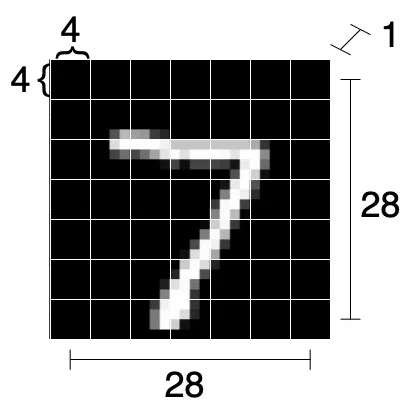


We modify our MyViT class to implement the patchifying only. We create a method that does the operation from scratch. Notice that this is an inefficient way to carry out the operation, but the code is intuitive for learning about the core concept.

In [ ]:
def patchify(images, n_patches):
    n, c, h, w = images.shape

    assert h == w, "Patchify method is implemented for square images only"

    patches = torch.zeros(n, n_patches ** 2, h * w * c // n_patches ** 2)
    patch_size = h // n_patches

    for idx, image in enumerate(images):
        for i in range(n_patches):
            for j in range(n_patches):
                patch = image[:, i * patch_size: (i + 1) * patch_size, j * patch_size: (j + 1) * patch_size]
                patches[idx, i * n_patches + j] = patch.flatten()
    return patches

In Python, the `assert` statement is used for debugging purposes. It checks if the given expression is true, and if it's not, it raises an `AssertionError` exception. The `assert` statement is typically used to catch programming errors during development.

In your specific case, `assert h == w` would check if the variables `h` and `w` are equal. If they are not equal, an `AssertionError` will be raised. If they are equal, the program continues execution without any issues.

Here's an example:

In [ ]:

h = 10
w = 10

assert h == w  # This will not raise an error because h is equal to w


If `h` and `w` are not equal, you would get an `AssertionError`:

In [ ]:
h = 10
w = 5

assert h == w  # This will raise an AssertionError because h is not equal to w

AssertionError: 

It's important to note that the use of `assert` statements in production code is generally discouraged. In production, it's better to handle errors using proper exception handling mechanisms.

In [ ]:
class MyViT(nn.Module):
  def __init__(self, chw=(1, 28, 28), n_patches=7):
    # Super constructor
    super(MyViT, self).__init__()

    # Attributes
    self.chw = chw # (C, H, W)
    self.n_patches = n_patches

    assert chw[1] % n_patches == 0, "Input shape not entirely divisible by number of patches"
    assert chw[2] % n_patches == 0, "Input shape not entirely divisible by number of patches"

  def forward(self, images):
    patches = patchify(images, self.n_patches)
    return patches

The class constructor now lets the class know the size of our input images (number of channels, height and width). Note that in this implementation, the n_patches variable is the number of patches that we will find both in width and height (in our case it’s 7 because we break the image into 7x7 patches).

We can test the functioning of our class with a simple main program:

In [ ]:
if __name__ == '__main__':
  # Current model
  model = MyViT(chw=(1, 28, 28),n_patches=7)

  x = torch.randn(7, 1, 28, 28) # Dummy images
  print(model(x).shape)

torch.Size([7, 49, 16])


Now that we have our flattened patches, we can map each of them through a Linear mapping. While each patch was a 4x4=16 dimensional vector, the linear mapping can map to any arbitrary vector size. Thus, we add a parameter to our class constructor, called hidden_d for ‘hidden dimension’.

In this example, we will use a hidden dimension of 8, but in principle, any number can be put here. We will thus be mapping each 16-dimensional patch to an 8-dimensional patch.

We simply create a nn.Linear layer and call it in our forward function.

In [ ]:
class MyViT(nn.Module):
  def __init__(self, chw=(1, 28, 28), n_patches=7):
    # Super constructor
    super(MyViT, self).__init__()

    # Attributes
    self.chw = chw # (C, H, W)
    self.n_patches = n_patches

    assert chw[1] % n_patches == 0, "Input shape not entirely divisible by number of patches"
    assert chw[2] % n_patches == 0, "Input shape not entirely divisible by number of patches"
    self.patch_size = (chw[1] / n_patches, chw[2] / n_patches)

    # 1) Linear mapper
    self.input_d = int(chw[0] * self.patch_size[0] * self.patch_size[1])
    self.linear_mapper = nn.Linear(self.input_d, self.hidden_d)

  def forward(self, images):
    patches = patchify(images, self.n_patches)
    tokens = self.linear_mapper(patches)
    return tokens

Notice that we run an (N, 49, 16) tensor through a (16, 8) linear mapper (or matrix). The linear operation only happens on the last dimension.

**Step 2: Adding the classification token**

If you look closely at the architecture picture, you will notice that also a “v_class” token is passed to the Transformer Encoder. What’s this?

Simply put, this is a special token that we add to our model that has the role of capturing information about the other tokens. This will happen with the MSA block (later on). When information about all other tokens will be present here, we will be able to classify the image using only this special token. The initial value of the special token (the one fed to the transformer encoder) is a parameter of the model that needs to be learned.

This is a cool concept of transformers! If we wanted to do another downstream task, we would just need to add another special token for the other downstream task (for example, classifying a digit as higher than 5 or lower) and a classifier that takes as input this new token. Clever, right?

We can now add a parameter to our model and convert our (N, 49, 8) tokens tensor to an (N, 50, 8) tensor (we add the special token to each sequence).

In [ ]:
class MyViT(nn.Module):
  def __init__(self, chw=(1, 28, 28), n_patches=7):
    # Super constructor
    super(MyViT, self).__init__()

    # Attributes
    self.chw = chw # (C, H, W)
    self.n_patches = n_patches

    assert chw[1] % n_patches == 0, "Input shape not entirely divisible by number of patches"
    assert chw[2] % n_patches == 0, "Input shape not entirely divisible by number of patches"
    self.patch_size = (chw[1] / n_patches, chw[2] / n_patches)

    # 1) Linear mapper
    self.input_d = int(chw[0] * self.patch_size[0] * self.patch_size[1])
    self.linear_mapper = nn.Linear(self.input_d, self.hidden_d)

    # 2) Learnable classifiation token
    self.class_token = nn.Parameter(torch.rand(1, self.hidden_d))

  def forward(self, images):
    patches = patchify(images, self.n_patches)
    tokens = self.linear_mapper(patches)

    # Adding classification token to the tokens
    tokens = torch.stack([torch.vstack((self.class_token, tokens[i])) for i in range(len(tokens))])
    return tokens

Notice that the classification token is put as the first token of each sequence. This will be important to keep in mind when we will then retrieve the classification token to feed to the final MLP.

**Step 3: Positional encoding**

As anticipated, positional encoding allows the model to understand where each patch would be placed in the original image. While it is theoretically possible to learn such positional embeddings, previous work by Vaswani et. al. suggests that we can just add sines and cosines waves.

In particular, positional encoding adds high-frequency values to the first dimensions and low-frequency values to the latter dimensions.

In each sequence, for token i we add to its j-th coordinate the following value:
Value to be added to the i-th tensor in its j-th coordinate.
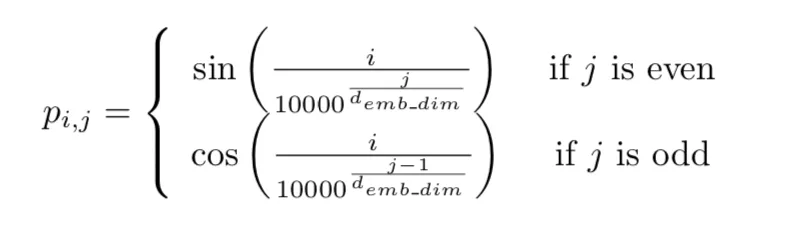

This positional embedding is a function of the number of elements in the sequence and the dimensionality of each element. Thus, it is always a 2-dimensional tensor or “rectangle”.

Here’s a simple function that, given the number of tokens and the dimensionality of each of them, outputs a matrix where each coordinate (i,j) is the value to be added to token i in dimension j.

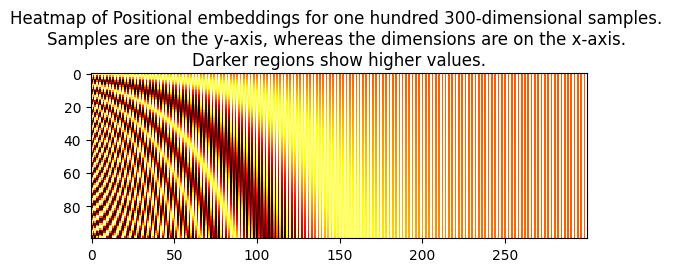

In [ ]:
def get_positional_embeddings(sequence_length, d):
    result = torch.ones(sequence_length, d)
    for i in range(sequence_length):
        for j in range(d):
            result[i][j] = np.sin(i / (10000 ** (j / d))) if j % 2 == 0 else np.cos(i / (10000 ** ((j - 1) / d)))
    return result

if __name__ == "__main__":
  import matplotlib.pyplot as plt

  plt.imshow(get_positional_embeddings(100, 300), cmap="hot", interpolation="nearest")
  plt.title("Heatmap of Positional embeddings for one hundred 300-dimensional samples. \nSamples are on the y-axis, whereas the dimensions are on the x-axis. \nDarker regions show higher values.")
  plt.show()

From the heatmap we have plotted, we see that all ‘horizontal lines’ are all different from each other, and thus samples can be distinguished.

We can now add this positional encoding to our model after the linear mapping and the addition of the class token.

In [ ]:
class MyViT(nn.Module):
  def __init__(self, chw=(1, 28, 28), n_patches=7):
    # Super constructor
    super(MyViT, self).__init__()

    # Attributes
    self.chw = chw # (C, H, W)
    self.n_patches = n_patches

    assert chw[1] % n_patches == 0, "Input shape not entirely divisible by number of patches"
    assert chw[2] % n_patches == 0, "Input shape not entirely divisible by number of patches"
    self.patch_size = (chw[1] / n_patches, chw[2] / n_patches)

    # 1) Linear mapper
    self.input_d = int(chw[0] * self.patch_size[0] * self.patch_size[1])
    self.linear_mapper = nn.Linear(self.input_d, self.hidden_d)

    # 2) Learnable classifiation token
    self.class_token = nn.Parameter(torch.rand(1, self.hidden_d))

    # 3) Positional embedding
    self.pos_embed = nn.Parameter(torch.tensor(get_positional_embeddings(self.n_patches ** 2 + 1, self.hidden_d)))
    self.pos_embed.requires_grad = False

  def forward(self, images):
    patches = patchify(images, self.n_patches)
    tokens = self.linear_mapper(patches)

    # Adding classification token to the tokens
    tokens = torch.stack([torch.vstack((self.class_token, tokens[i])) for i in range(len(tokens))])

    # Adding positional embedding
    pos_embed = self.pos_embed.repeat(n, 1, 1)
    out = tokens + pos_embed
    return out

We define the positional embedding to be a parameter of our model (that we won’t update by setting its requires_grad to False). Note that in the forward method, since tokens have size (N, 50, 8), we have to repeat the (50, 8) positional encoding matrix N times.

# **Step 4: The encoder block (Part 1/2)**

This is possibly the hardest step of all. An encoder block takes as input our current tensor [N, S, D] and outputs a tensor of the same dimensionality.

 The notation [N, S, D] refers to the dimensions or parameters of each token in the encoder block. Here's what each symbol represents:

1. **N:** Number of tokens in the input sequence.
   - N is the sequence length, and it corresponds to the number of patches or tokens obtained by dividing the input image into non-overlapping patches.

2. **S:** Embedding dimension or size of each token.
   - S represents the dimensionality of the embedding space for each token. In ViT, each patch is linearly embedded into a vector of size S. This embedding is often followed by positional encoding to provide spatial information.

3. **D:** Dimension of the model or the hidden layer dimension.
   - D denotes the dimensionality of the hidden layers in the transformer model. It is the size of the intermediate representation in the self-attention mechanism.

In a typical transformer-based encoder block, the input tokens (patch embeddings) undergo various operations, such as self-attention, normalization, and feedforward transformations. The attention mechanism allows each token to attend to all other tokens, capturing global dependencies. These operations help in capturing hierarchical features and relationships within the input sequence.

In summary, the [N, S, D] notation provides information about the dimensions of the input sequence (number of tokens), the embedding space (size of each token's embedding), and the hidden layer dimension (size of the intermediate representation in the transformer's self-attention mechanism). These parameters play a crucial role in the architecture and design of the ViT model.

The first part of the encoder block applies Layer Normalization to our tokens, then a Multi-head Self Attention, and finally adds a residual connection.

**Layer Normalization**

Layer normalization is a popular block that, given an input, subtracts its mean and divides by the standard deviation.

However, we commonly apply layer normalization to an (N, d) input, where d is the dimensionality. Luckily, also the Layer Normalization module generalizes to multiple dimensions, check this:



In [ ]:
ln = nn.LayerNorm(8)

print(ln(torch.rand(50,8)).shape)

torch.Size([50, 8])


In [ ]:
print(ln(torch.rand(16,50,8)).shape)

torch.Size([16, 50, 8])


nn.LayerNorm can be applied in multiple dimensions. We can normalize fifty 8-dimensional vectors, but we can also normalize sixteen by fifty 8-dimensional vectors.

Layer normalization is applied to the last dimension only. We can thus make each of our 50x8 matrices (representing a single sequence) have mean 0 and std 1. After we run our (N, 50, 8) tensor through LN, we still get the same dimensionality.

**Multi-head Self Attention**

We now need to implement sub-figure c of the architecture picture. What’s happening there?

Simply put: we want, for a single image, each patch to get updated based on some similarity measure with the other patches. We do so by linearly mapping each patch (that is now an 8-dimensional vector in our example) to 3 distinct vectors: q, k, and v (query, key, value).

Then, for a single patch, we are going to compute the dot product between its q vector with all of the k vectors, divide by the square root of the dimensionality of these vectors (sqrt(8)), softmax these so-called attention cues, and finally multiply each attention cue with the v vectors associated with the different k vectors and sum all up.

In this way, each patch assumes a new value that is based on its similarity (after the linear mapping to q, k, and v) with other patches. This whole procedure, however, is carried out H times on H sub-vectors of our current 8-dimensional patches, where H is the number of Heads. If you’re unfamiliar with the attention and multi-head attention mechanisms, I suggest you read the post by Yasuto Tamura.

Once all results are obtained, they are concatenated together. Finally, the result is passed through a linear layer (for good measure).

The intuitive idea behind attention is that it allows modeling the relationship between the inputs. What makes a ‘0’ a zero are not the individual pixel values, but how they relate to each other.

Since quite some computations are carried out, it is worth creating a new class for MSA:

In [ ]:
class MyMSA(nn.Module):
    def __init__(self, d, n_heads=2):
        super(MyMSA, self).__init__()
        self.d = d
        self.n_heads = n_heads

        assert d % n_heads == 0, f"Can't divide dimension {d} into {n_heads} heads"

        d_head = int(d / n_heads)
        self.q_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.k_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.v_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.d_head = d_head
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, sequences):
        # Sequences has shape (N, seq_length, token_dim)
        # We go into shape    (N, seq_length, n_heads, token_dim / n_heads)
        # And come back to    (N, seq_length, item_dim)  (through concatenation)
        result = []
        for sequence in sequences:
            seq_result = []
            for head in range(self.n_heads):
                q_mapping = self.q_mappings[head]
                k_mapping = self.k_mappings[head]
                v_mapping = self.v_mappings[head]

                seq = sequence[:, head * self.d_head: (head + 1) * self.d_head]
                q, k, v = q_mapping(seq), k_mapping(seq), v_mapping(seq)

                attention = self.softmax(q @ k.T / (self.d_head ** 0.5))
                seq_result.append(attention @ v)
            result.append(torch.hstack(seq_result))
        return torch.cat([torch.unsqueeze(r, dim=0) for r in result])

Notice that, for each head, we create distinct Q, K, and V mapping functions (square matrices of size 4x4 in our example).

Since our inputs will be sequences of size (N, 50, 8), and we only use 2 heads, we will at some point have an (N, 50, 2, 4) tensor, use a nn.Linear(4, 4) module on it, and then come back, after concatenation, to an (N, 50, 8) tensor.

Also notice that using loops is not the most efficient way to compute the multi-head self-attention, but it makes the code much clearer for learning.

**Residual connection**

A residual connection consists in just adding the original input to the result of some computation. This, intuitively, allows a network to become more powerful while also preserving the set of possible functions that the model can approximate.

We will add a residual connection that will add our original (N, 50, 8) tensor to the (N, 50, 8) obtained after LN and MSA. It’s time to create the transformer encoder block class, which will be a component of the MyViT class:

In [ ]:
class MyViTBlock(nn.Module):
    def __init__(self, hidden_d, n_heads, mlp_ratio=4):
        super(MyViTBlock, self).__init__()
        self.hidden_d = hidden_d
        self.n_heads = n_heads

        self.norm1 = nn.LayerNorm(hidden_d)
        self.mhsa = MyMSA(hidden_d, n_heads)

    def forward(self, x):
        out = x + self.mhsa(self.norm1(x))
        return out

Phew, that was quite some work! But I promise this was the hardest part. From now on, it’s all downhill.

With this self-attention mechanism, the class token (first token of each of the N sequences) now has information regarding all other tokens!

**Step 5: The encoder block (Part 2/2)**

All that is left to the transformer encoder is just a simple residual connection between what we already have and what we get after passing the current tensor through another LN and an MLP. The MLP is composed of two layers, where the hidden layer typically is four times as big (this is a parameter)

In [ ]:
class MyViTBlock(nn.Module):
    def __init__(self, hidden_d, n_heads, mlp_ratio=4):
        super(MyViTBlock, self).__init__()
        self.hidden_d = hidden_d
        self.n_heads = n_heads

        self.norm1 = nn.LayerNorm(hidden_d)
        self.mhsa = MyMSA(hidden_d, n_heads)
        self.norm2 = nn.LayerNorm(hidden_d)
        self.mlp = nn.Sequential(nn.Linear(hidden_d, mlp_ratio * hidden_d),nn.GELU(),nn.Linear(mlp_ratio * hidden_d, hidden_d))

    def forward(self, x):
        out = x + self.mhsa(self.norm1(x))
        out = out + self.mlp(self.norm2(out))
        return out



We can indeed see that the Encoder block outputs a tensor of the same dimensionality:

In [ ]:
if __name__ == '__main__':
  model = MyViTBlock(hidden_d=8, n_heads=2)

  x = torch.randn(7, 50, 8)
  print(model(x).shape)

torch.Size([7, 50, 8])


Now that the encoder block is ready, we just need to insert it in our bigger ViT model which is responsible for patchifying before the transformer blocks, and carrying out the classification after.

We could have an arbitrary number of transformer blocks. In this example, to keep it simple, I will use only 2. We also add a parameter to know how many heads does each encoder block will use.

In [ ]:
class MyViT(nn.Module):
    def __init__(self, chw, n_patches=7, n_blocks=2, hidden_d=8, n_heads=2, out_d=10):
        # Super constructor
        super(MyViT, self).__init__()

        # Attributes
        self.chw = chw # ( C , H , W )
        self.n_patches = n_patches
        self.n_blocks = n_blocks
        self.n_heads = n_heads
        self.hidden_d = hidden_d

        # Input and patches sizes
        assert chw[1] % n_patches == 0, "Input shape not entirely divisible by number of patches"
        assert chw[2] % n_patches == 0, "Input shape not entirely divisible by number of patches"
        self.patch_size = (chw[1] / n_patches, chw[2] / n_patches)

        # 1) Linear mapper
        self.input_d = int(chw[0] * self.patch_size[0] * self.patch_size[1])
        self.linear_mapper = nn.Linear(self.input_d, self.hidden_d)

        # 2) Learnable classification token
        self.class_token = nn.Parameter(torch.rand(1, self.hidden_d))

        # 3) Positional embedding
        self.register_buffer('positional_embeddings', get_positional_embeddings(n_patches ** 2 + 1, hidden_d), persistent=False)

        # 4) Transformer encoder blocks
        self.blocks = nn.ModuleList([MyViTBlock(hidden_d, n_heads) for _ in range(n_blocks)])

    def forward(self, images):
        # Dividing images into patches
        n, c, h, w = images.shape
        patches = patchify(images, self.n_patches).to(self.positional_embeddings.device)

        # Running linear layer tokenization
        # Map the vector corresponding to each patch to the hidden size dimension
        tokens = self.linear_mapper(patches)

        # Adding classification token to the tokens
        tokens = torch.cat((self.class_token.expand(n, 1, -1), tokens), dim=1)

        # Adding positional embedding
        out = tokens + self.positional_embeddings.repeat(n, 1, 1)

        # Transformer Blocks
        for block in self.blocks:
            out = block(out)

        return out

Once more, if we run a random (7, 1, 28, 28) tensor through our model, we still get a (7, 50, 8) tensor.

**Step 6: Classification MLP**

Finally, we can extract just the classification token (first token) out of our N sequences, and use each token to get N classifications.

Since we decided that each token is an 8-dimensional vector, and since we have 10 possible digits, we can implement the classification MLP as a simple 8x10 matrix, activated with the SoftMax function.

In [ ]:
class MyViT(nn.Module):
    def __init__(self, chw, n_patches=7, n_blocks=2, hidden_d=8, n_heads=2, out_d=10):
        # Super constructor
        super(MyViT, self).__init__()

        # Attributes
        self.chw = chw # ( C , H , W )
        self.n_patches = n_patches
        self.n_blocks = n_blocks
        self.n_heads = n_heads
        self.hidden_d = hidden_d

        # Input and patches sizes
        assert chw[1] % n_patches == 0, "Input shape not entirely divisible by number of patches"
        assert chw[2] % n_patches == 0, "Input shape not entirely divisible by number of patches"
        self.patch_size = (chw[1] / n_patches, chw[2] / n_patches)

        # 1) Linear mapper
        self.input_d = int(chw[0] * self.patch_size[0] * self.patch_size[1])
        self.linear_mapper = nn.Linear(self.input_d, self.hidden_d)

        # 2) Learnable classification token
        self.class_token = nn.Parameter(torch.rand(1, self.hidden_d))

        # 3) Positional embedding
        self.register_buffer('positional_embeddings', get_positional_embeddings(n_patches ** 2 + 1, hidden_d), persistent=False)

        # 4) Transformer encoder blocks
        self.blocks = nn.ModuleList([MyViTBlock(hidden_d, n_heads) for _ in range(n_blocks)])

        # 5) Classification MLPk
        self.mlp = nn.Sequential(
            nn.Linear(self.hidden_d, out_d),
            nn.Softmax(dim=-1)
        )

    def forward(self, images):
        # Dividing images into patches
        n, c, h, w = images.shape
        patches = patchify(images, self.n_patches).to(self.positional_embeddings.device)

        # Running linear layer tokenization
        # Map the vector corresponding to each patch to the hidden size dimension
        tokens = self.linear_mapper(patches)

        # Adding classification token to the tokens
        tokens = torch.cat((self.class_token.expand(n, 1, -1), tokens), dim=1)

        # Adding positional embedding
        out = tokens + self.positional_embeddings.repeat(n, 1, 1)

        # Transformer Blocks
        for block in self.blocks:
            out = block(out)

        # Getting the classification token only
        out = out[:, 0]

        return self.mlp(out) # Map to output dimension, output category distribution

The output of our model is now an (N, 10) tensor. Hurray, we are done!



# **Results**

We change the only line in the main program that was previously undefined.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MyViT((1, 28, 28), n_patches=7, n_blocks=2, hidden_d=8, n_heads=2, out_d=10).to(device)

We now just need to run the training and test loops and see how our model performs.

In [ ]:
import numpy as np
import torch
import torch.nn as nn
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision.datasets.mnist import MNIST
from torchvision.transforms import ToTensor
from tqdm import tqdm, trange

np.random.seed(0)
torch.manual_seed(0)


def patchify(images, n_patches):
    n, c, h, w = images.shape

    assert h == w, "Patchify method is implemented for square images only"

    patches = torch.zeros(n, n_patches**2, h * w * c // n_patches**2)
    patch_size = h // n_patches

    for idx, image in enumerate(images):
        for i in range(n_patches):
            for j in range(n_patches):
                patch = image[
                    :,
                    i * patch_size : (i + 1) * patch_size,
                    j * patch_size : (j + 1) * patch_size,
                ]
                patches[idx, i * n_patches + j] = patch.flatten()
    return patches


class MyMSA(nn.Module):
    def __init__(self, d, n_heads=2):
        super(MyMSA, self).__init__()
        self.d = d
        self.n_heads = n_heads

        assert d % n_heads == 0, f"Can't divide dimension {d} into {n_heads} heads"

        d_head = int(d / n_heads)
        self.q_mappings = nn.ModuleList(
            [nn.Linear(d_head, d_head) for _ in range(self.n_heads)]
        )
        self.k_mappings = nn.ModuleList(
            [nn.Linear(d_head, d_head) for _ in range(self.n_heads)]
        )
        self.v_mappings = nn.ModuleList(
            [nn.Linear(d_head, d_head) for _ in range(self.n_heads)]
        )
        self.d_head = d_head
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, sequences):
        # Sequences has shape (N, seq_length, token_dim)
        # We go into shape    (N, seq_length, n_heads, token_dim / n_heads)
        # And come back to    (N, seq_length, item_dim)  (through concatenation)
        result = []
        for sequence in sequences:
            seq_result = []
            for head in range(self.n_heads):
                q_mapping = self.q_mappings[head]
                k_mapping = self.k_mappings[head]
                v_mapping = self.v_mappings[head]

                seq = sequence[:, head * self.d_head : (head + 1) * self.d_head]
                q, k, v = q_mapping(seq), k_mapping(seq), v_mapping(seq)

                attention = self.softmax(q @ k.T / (self.d_head**0.5))
                seq_result.append(attention @ v)
            result.append(torch.hstack(seq_result))
        return torch.cat([torch.unsqueeze(r, dim=0) for r in result])


class MyViTBlock(nn.Module):
    def __init__(self, hidden_d, n_heads, mlp_ratio=4):
        super(MyViTBlock, self).__init__()
        self.hidden_d = hidden_d
        self.n_heads = n_heads

        self.norm1 = nn.LayerNorm(hidden_d)
        self.mhsa = MyMSA(hidden_d, n_heads)
        self.norm2 = nn.LayerNorm(hidden_d)
        self.mlp = nn.Sequential(
            nn.Linear(hidden_d, mlp_ratio * hidden_d),
            nn.GELU(),
            nn.Linear(mlp_ratio * hidden_d, hidden_d),
        )

    def forward(self, x):
        out = x + self.mhsa(self.norm1(x))
        out = out + self.mlp(self.norm2(out))
        return out


class MyViT(nn.Module):
    def __init__(self, chw, n_patches=7, n_blocks=2, hidden_d=8, n_heads=2, out_d=10):
        # Super constructor
        super(MyViT, self).__init__()

        # Attributes
        self.chw = chw  # ( C , H , W )
        self.n_patches = n_patches
        self.n_blocks = n_blocks
        self.n_heads = n_heads
        self.hidden_d = hidden_d

        # Input and patches sizes
        assert (
            chw[1] % n_patches == 0
        ), "Input shape not entirely divisible by number of patches"
        assert (
            chw[2] % n_patches == 0
        ), "Input shape not entirely divisible by number of patches"
        self.patch_size = (chw[1] / n_patches, chw[2] / n_patches)

        # 1) Linear mapper
        self.input_d = int(chw[0] * self.patch_size[0] * self.patch_size[1])
        self.linear_mapper = nn.Linear(self.input_d, self.hidden_d)

        # 2) Learnable classification token
        self.class_token = nn.Parameter(torch.rand(1, self.hidden_d))

        # 3) Positional embedding
        self.register_buffer(
            "positional_embeddings",
            get_positional_embeddings(n_patches**2 + 1, hidden_d),
            persistent=False,
        )

        # 4) Transformer encoder blocks
        self.blocks = nn.ModuleList(
            [MyViTBlock(hidden_d, n_heads) for _ in range(n_blocks)]
        )

        # 5) Classification MLPk
        self.mlp = nn.Sequential(nn.Linear(self.hidden_d, out_d), nn.Softmax(dim=-1))

    def forward(self, images):
        # Dividing images into patches
        n, c, h, w = images.shape
        patches = patchify(images, self.n_patches).to(self.positional_embeddings.device)

        # Running linear layer tokenization
        # Map the vector corresponding to each patch to the hidden size dimension
        tokens = self.linear_mapper(patches)

        # Adding classification token to the tokens
        tokens = torch.cat((self.class_token.expand(n, 1, -1), tokens), dim=1)

        # Adding positional embedding
        out = tokens + self.positional_embeddings.repeat(n, 1, 1)

        # Transformer Blocks
        for block in self.blocks:
            out = block(out)

        # Getting the classification token only
        out = out[:, 0]

        return self.mlp(out)  # Map to output dimension, output category distribution


def get_positional_embeddings(sequence_length, d):
    result = torch.ones(sequence_length, d)
    for i in range(sequence_length):
        for j in range(d):
            result[i][j] = (
                np.sin(i / (10000 ** (j / d)))
                if j % 2 == 0
                else np.cos(i / (10000 ** ((j - 1) / d)))
            )
    return result


def main():
    # Loading data
    transform = ToTensor()

    train_set = MNIST(
        root="./../datasets", train=True, download=True, transform=transform
    )
    test_set = MNIST(
        root="./../datasets", train=False, download=True, transform=transform
    )

    train_loader = DataLoader(train_set, shuffle=True, batch_size=128)
    test_loader = DataLoader(test_set, shuffle=False, batch_size=128)

    # Defining model and training options
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device: ",device,f"({torch.cuda.get_device_name(device)})" if torch.cuda.is_available() else "",)

    model = MyViT((1, 28, 28), n_patches=7, n_blocks=2, hidden_d=8, n_heads=2, out_d=10).to(device)
    N_EPOCHS = 5
    LR = 0.005

    # Training loop
    optimizer = Adam(model.parameters(), lr=LR)
    criterion = CrossEntropyLoss()
    for epoch in trange(N_EPOCHS, desc="Training"):
        train_loss = 0.0
        for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1} in training", leave=False):
            x, y = batch
            x, y = x.to(device), y.to(device)
            y_hat = model(x)
            loss = criterion(y_hat, y)

            train_loss += loss.detach().cpu().item() / len(train_loader)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch + 1}/{N_EPOCHS} loss: {train_loss:.2f}")

    # Test loop
    with torch.no_grad():
        correct, total = 0, 0
        test_loss = 0.0
        for batch in tqdm(test_loader, desc="Testing"):
            x, y = batch
            x, y = x.to(device), y.to(device)
            y_hat = model(x)
            loss = criterion(y_hat, y)
            test_loss += loss.detach().cpu().item() / len(test_loader)

            correct += torch.sum(torch.argmax(y_hat, dim=1) == y).detach().cpu().item()
            total += len(x)
        print(f"Test loss: {test_loss:.2f}")
        print(f"Test accuracy: {correct / total * 100:.2f}%")


if __name__ == "__main__":
    main()

100%|██████████| 9912422/9912422 [00:00<00:00, 111049203.36it/s]


Extracting ./../datasets/MNIST/raw/train-images-idx3-ubyte.gz to ./../datasets/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 71847979.73it/s]


Extracting ./../datasets/MNIST/raw/train-labels-idx1-ubyte.gz to ./../datasets/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 27658144.59it/s]


Extracting ./../datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to ./../datasets/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 13976910.32it/s]


Extracting ./../datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./../datasets/MNIST/raw

Using device:  cpu 


Training:  20%|██        | 1/5 [03:48<15:13, 228.31s/it]

Epoch 1/5 loss: 2.11



Training:  40%|████      | 2/5 [07:32<11:18, 226.16s/it]

Epoch 2/5 loss: 1.86



Training:  60%|██████    | 3/5 [11:18<07:31, 225.93s/it]

Epoch 3/5 loss: 1.78



Training:  80%|████████  | 4/5 [15:06<03:46, 226.59s/it]

Epoch 4/5 loss: 1.74



Training: 100%|██████████| 5/5 [18:53<00:00, 226.62s/it]


Epoch 5/5 loss: 1.71


Testing: 100%|██████████| 79/79 [00:18<00:00,  4.19it/s]

Test loss: 1.70
Test accuracy: 76.35%


And that’s it! We have now created a ViT from scratch. Our model achieves ~76% accuracy in just 5 epochs and with few parameters.